In [1]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing
from keras.datasets import imdb

import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드

In [4]:
# 단어의 최대 개수
max_words = 10000

# 한 문장에서 단어 시퀀스의 최대 개수(?)
max_sequences = 500

# 임베딩 벡터 차원(?)
embedding_dim = 100

# IMDb 리뷰 데이터를 최대 단어 10000개로 제한하여 가져옴
(train_data, train_labels),(test_data, test_labels) = imdb.load_data(num_words = max_words)

17465344/17464789 [==============================] - 5s 0us/step


In [14]:
# 훈련셋 크기
train_data.shape

(25000,)

In [8]:
train_labels.shape

(25000,)

In [9]:
test_data.shape

(25000,)

In [10]:
test_labels.shape

(25000,)

# 전처리

In [49]:
# 훈련셋에 패딩 추가
# 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용
# pad_sequences()함수는 maxlen만큼 0으로 패딩을 추가, 보통 텍스트를 처리할 때, 이렇게 입력을 동일한 길이로 맞추는 작업. 디폴트는 padding='pre'
x_train = preprocessing.sequence.pad_sequences(train_data, maxlen = max_sequences, padding='post')

x_test = preprocessing.sequence.pad_sequences(test_data, maxlen = max_sequences, padding='post')

In [18]:
x_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [27]:
# 레이블을 벡터로 변환
# 0,1 정수를 그냥 실수로 변환하는 것
y_train = np.asarray(train_labels).astype('float32')
y_train
# train_labels
y_test = np.asarray(test_labels).astype('float32')
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [30]:
# 훈련셋에서 검증셋 분리
x_val = x_train[:10000]
x_train_new = x_train[10000:]

y_val = y_train[:10000]
y_train_new = y_train[10000:]

# 모델 생성

In [34]:
def build_model():
    
    model = models.Sequential()
    model.add(layers.Embedding(max_words, embedding_dim, input_length = max_sequences)) # 단어 집합의 크기, 임베딩한 후 벡터의 크기(출력 차원), 각 입력 시퀀스의 길이
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(64,8,activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(64,8,activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
    return model

# Embedding()은 단어를 밀집 벡터로 만드는 역할, 인공 신경망 용어로는 임베딩 층을 만드는 역할(기하공간에 매핑할 수 있도록)
# Embedding()은 정수 인코딩이 된 단어들을 입력받아서 임베딩 수행
# GlobalMaxPooling1D - 여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환(즉 문맥을 보면서 주요 특징을 뽑아내고, 그 중 가장 두드러지는 특징을 고르는 것)
# MaxPooling1D - 입력 벡터에서 특정 구간마다 값을 골라 벡터를 구성한 후 반환


In [35]:
# 모델의 구조 출력
# GlobalMaxPooling1D(91의 입력을 전체 맥스 풀링하여 1개로 출력)
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 493, 64)           51264     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 91, 64)            32832     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [39]:
# 훈련 시작
history = model.fit(x_train_new, y_train_new, epochs=11, batch_size=512, validation_data=(x_val, y_val))


Train on 15000 samples, validate on 10000 samples
Epoch 1/11
15000/15000 [==============================] - 1s 67us/step - loss: 0.0726 - acc: 0.9735 - val_loss: 0.4078 - val_acc: 0.8747
Epoch 2/11
15000/15000 [==============================] - 1s 66us/step - loss: 0.0710 - acc: 0.9775 - val_loss: 0.4707 - val_acc: 0.8663
Epoch 3/11
15000/15000 [==============================] - 1s 66us/step - loss: 0.0576 - acc: 0.9814 - val_loss: 0.4746 - val_acc: 0.8713
Epoch 4/11
15000/15000 [==============================] - 1s 66us/step - loss: 0.0147 - acc: 0.9966 - val_loss: 1.3477 - val_acc: 0.7536
Epoch 5/11
15000/15000 [==============================] - 1s 66us/step - loss: 0.0416 - acc: 0.9863 - val_loss: 0.5496 - val_acc: 0.8690
Epoch 6/11
15000/15000 [==============================] - 1s 66us/step - loss: 0.0504 - acc: 0.9856 - val_loss: 0.5844 - val_acc: 0.8687
Epoch 7/11
15000/15000 [==============================] - 1s 66us/step - loss: 0.0035 - acc: 0.9997 - val_loss: 0.6252 - val_acc

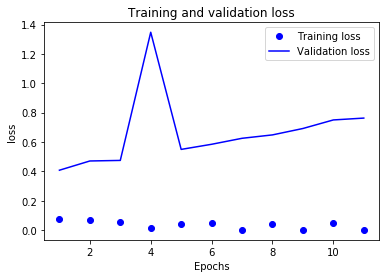

In [42]:
loss = history.history['loss'] # 훈련 손실
val_loss = history.history['val_loss'] # 검증 손실

epochs = range(1, len(loss)+1) # len(loss)=epochs

plt.plot(epochs, loss, 'bo',label='Training loss') # 'bo'는 파란색 점
plt.plot(epochs, val_loss, 'b',label = 'Validation loss') # 'b'는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

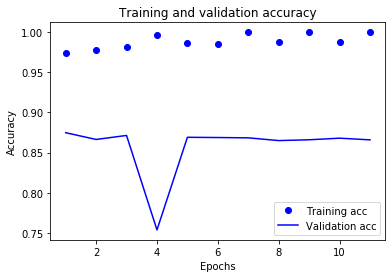

In [44]:
# 그래프 초기화
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo',label='Training acc')
plt.plot(epochs, val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [46]:
model.save('D://STUDY//model/movie_review_conv1d_model.h5')


In [47]:
model = models.load_model('D://STUDY//model/movie_review_conv1d_model.h5')

In [50]:
results = model.evaluate(x_test,y_test)
results

25000/25000 [==============================] - 2s 63us/step


[0.8434820417115092, 0.8493199944496155]